In [1]:
import sympy as sp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
# Weights
w_c, w_l, w_s = sp.symbols('w_c w_l w_s', positive=True)
# Token balances
x_c, x_l, x_s = sp.symbols('x_c x_l x_s', positive=True)
# Prices - in units of locked up collateral
v = sp.symbols('v', positive=True) 
# Swap fee in fraction of input tokens
s_f = sp.symbols('s_f')
# Decimal scaling 
d_c, d_p = sp.symbols('d_c d_p', positive=True)
# Collateral backing L + S 
# e.g. for $100.000_000_000_000_000_000 = 1.000_000 mt
# this is 100*10**18 / 1*10**6 = 10**14
C = sp.symbols('C', positive=True)

In [4]:
def calc_spot_price(bI, wI, bO, wO, sF=0):
    """
    calcSpotPrice                                                                             //
     sP = spotPrice                                                                            //
     bI = tokenBalanceIn                ( bI / wI )         1                                  //
     bO = tokenBalanceOut         sP =  -----------  *  ----------                             //
     wI = tokenWeightIn                 ( bO / wO )     ( 1 - sF )                             //
     wO = tokenWeightOut                                                                       //
     sF = swapFee 
    """
    return (bI/wI)/(bO/wO)/(1-sF)

In [5]:
# e.g. condition for spot price of long token without fees to be v*C
calc_spot_price(x_c, w_c, x_l, w_l) - v*C

-C*v + w_l*x_c/(w_c*x_l)

In [6]:
sol = sp.solve(
    [w_c + w_l + w_s - 1,   # Weights sum to 1
     calc_spot_price(x_c, w_c, x_l, w_l, 0) - v*C,      # Long token price = v*C
     calc_spot_price(x_c, w_c, x_s, w_s, 0) - (1-v)*C,  # Short token price = (1-v)*C
    ]
     , [w_c, w_l, w_s])

In [7]:
sol[w_c]

x_c/(C*v*x_l - C*x_s*(v - 1) + x_c)

In [8]:
sol[w_l]

C*v*x_l/(C*v*x_l - C*x_s*(v - 1) + x_c)

In [9]:
sol[w_s]

-C*x_s*(v - 1)/(C*v*x_l - C*x_s*(v - 1) + x_c)

In [10]:
# Full set of weights needed to set the spot prices of long and short tokens
sol

{w_c: x_c/(C*v*x_l - C*x_s*(v - 1) + x_c),
 w_l: C*v*x_l/(C*v*x_l - C*x_s*(v - 1) + x_c),
 w_s: -C*x_s*(v - 1)/(C*v*x_l - C*x_s*(v - 1) + x_c)}

In [11]:
# Check spot prices
calc_spot_price(x_c, w_c, x_l, w_l, s_f).subs(sol) # Long spot price

C*v/(1 - s_f)

In [12]:
calc_spot_price(x_c, w_c, x_s, w_s, s_f).subs(sol)

-C*(v - 1)/(1 - s_f)

In [13]:
def calc_out_given_in(bO, wO, bI, wI, aI, sF=0):
    """
    calcOutGivenIn                                                                            //
     aO = tokenAmountOut                                                                       //
     bO = tokenBalanceOut                                                                      //
     bI = tokenBalanceIn              /      /            bI             \    (wI / wO) \      //
     aI = tokenAmountIn    aO = bO * |  1 - | --------------------------  | ^            |     //
     wI = tokenWeightIn               \      \ ( bI + ( aI * ( 1 - sF )) /              /      //
     wO = tokenWeightOut                                                                       //
     sF = swapFee 
    """
    return bO*(1-(bI/(bI + (aI*(1-sF))))**(wI/wO))

In [14]:
def calc_in_given_out(bO, wO, bI, wI, aO, sF=0):
    """
    calcInGivenOut                                                                            //
     aI = tokenAmountIn                                                                        //
     bO = tokenBalanceOut               /  /     bO      \    (wO / wI)      \                 //
     bI = tokenBalanceIn          bI * |  | ------------  | ^            - 1  |                //
     aO = tokenAmountOut    aI =        \  \ ( bO - aO ) /                   /                 //
     wI = tokenWeightIn           --------------------------------------------                 //
     wO = tokenWeightOut                          ( 1 - sF )                                   //
     sF = swapFee                                               
    """
    return bI*((bO/(bO - aO))**(wO/wI) - 1)/(1-sF)

In [15]:
# Input token amounts for swaps
a_c, a_l, a_s = sp.symbols('a_c a_l a_s', positive=True)

In [16]:
n, d = sp.fraction(w_c.subs(sol))

In [17]:
w_c.subs(sol).subs({d: 1})

x_c

# Check for arbitrage: buy L, buy S, redeem for C


In [18]:
# Buy long tokens for a_c collateral tokens
x_l_O = calc_out_given_in(x_l, w_l, x_c, w_c, a_c, s_f).subs(sol).simplify()

In [19]:
# Updated balance in pool
x_l_1 = x_l - x_l_O
x_c_1 = x_c + a_c

In [20]:
# Buy same amount of short tokens 
x_c_I = calc_in_given_out(x_s, w_s, x_c_1, w_c, x_l_O, s_f).subs(sol).simplify()

In [21]:
trade_cost = (a_c + x_c_I).simplify() # Buy long from pool, buy same amount of short
trade_revenue = (C*x_l_O).simplify()  # Redeem long-short pair for underlying collateral

In [22]:
# Input as fraction of balance i.e. a_c = f_c * x_c
f_c, f_l, f_s = sp.symbols('f_c f_l f_s', positive=True)

In [23]:
trade_cost.subs({a_c: f_c*x_c}).simplify()

f_c*x_c + (1 - (x_s/(x_l*(x_c/(-f_c*s_f*x_c + f_c*x_c + x_c))**(x_c/(C*v*x_l)) - x_l + x_s))**(-C*x_s*(v - 1)/x_c))*(f_c*x_c + x_c)/(s_f - 1)

In [24]:
# Look at first and second order revenue - cost 
sp.series((trade_revenue - trade_cost).subs({a_c: f_c*x_c}).simplify(), f_c, n=2).coeff(f_c, 1).simplify()

-s_f*x_c/v

In [25]:
n=2
sp.series((trade_revenue - trade_cost).subs({a_c: f_c*x_c}).simplify(), f_c, n=n+1).coeff(f_c, n).simplify().collect(v)

x_c*(2*C*s_f*v**2*x_l*x_s + C*s_f*x_l*x_s - C*x_l*x_s - s_f**2*x_c*x_s + s_f*x_c*x_l + s_f*x_c*x_s + v*(-C*s_f**2*x_l*x_s - C*s_f*x_l*x_s - s_f*x_c*x_l + s_f*x_c*x_s + x_c*x_l - x_c*x_s) - x_c*x_l)/(2*C*v**2*x_l*x_s)

# Check for arbitrage: mint from C, sell L, sell S 

In [26]:
# Buy coin tokens for long tokens
x_c_O = calc_out_given_in(x_c, w_c, x_l, w_l, a_l, s_f).subs(sol).simplify()

In [27]:
# Updated balance in pool
y_l_1 = x_l + a_l
y_c_1 = x_c - x_c_O

In [28]:
# Buy coin tokens for same amount of short tokens 
x_c_O_2 = calc_out_given_in(y_c_1, w_c, x_s, w_s, a_l, s_f).subs(sol).simplify()

In [29]:
trade_cost_mint = (a_l * C).simplify() # Mint long and short 
trade_revenue_mint = (x_c_O + x_c_O_2).simplify()  # Redeem long-short pair for underlying collateral

In [30]:
trade_cost_mint

C*a_l

In [31]:
trade_revenue_mint

-x_c*(x_l/(-a_l*s_f + a_l + x_l))**(C*v*x_l/x_c)*(x_s/(-a_l*s_f + a_l + x_s))**(C*x_s/x_c)*(x_s/(-a_l*s_f + a_l + x_s))**(-C*v*x_s/x_c) + x_c

In [32]:
sp.series((trade_revenue_mint - trade_cost_mint).subs({a_l: f_l*x_l}).simplify(), f_l, n=3)#.coeff(f_l, 1).simplify()

f_l**2*(-C**2*s_f**2*x_l**2/(2*x_c) + C**2*s_f*x_l**2/x_c - C**2*x_l**2/(2*x_c) + C*s_f**2*v*x_l**2/(2*x_s) - C*s_f**2*v*x_l/2 - C*s_f**2*x_l**2/(2*x_s) - C*s_f*v*x_l**2/x_s + C*s_f*v*x_l + C*s_f*x_l**2/x_s + C*v*x_l**2/(2*x_s) - C*v*x_l/2 - C*x_l**2/(2*x_s)) - C*f_l*s_f*x_l + O(f_l**3)

# Next section WIP - ignore

Consider now pair balance and difference with $x_l = (x_p + x_d)/2$ and $x_s = (x_p - x_d)/2$ so that we can introduce a budget constraint $x_c + C*x_p = b_c$

In [33]:
x_p, x_d = sp.symbols('x_p x_c')
subs_dict = {x_l: (x_p + x_d)/2, x_s: (x_p - x_d)/2}

In [34]:
b_c = sp.symbols('b_c')
budget_subs_dict = {x_c: b_c - C*x_p}

In [35]:
sol[w_c].subs(subs_dict).simplify()

2*x_c/(2*C*v*x_c - C*x_c + C*x_p + 2*x_c)

In [36]:
sol[w_l].subs(subs_dict).simplify()

C*v*(x_c + x_p)/(2*C*v*x_c - C*x_c + C*x_p + 2*x_c)

In [37]:
sol[w_s].subs(subs_dict).simplify()

C*(v - 1)*(x_c - x_p)/(C*v*(x_c + x_p) + C*(v - 1)*(x_c - x_p) + 2*x_c)

In [38]:
(sol[w_c] + sol[w_l] + sol[w_s]).simplify()

1

In [39]:
sol[w_c].subs(subs_dict).subs(budget_subs_dict).simplify()

(-2*C*x_p + 2*b_c)/(2*C*v*x_c - C*x_c - C*x_p + 2*b_c)

In [40]:
sol[w_c].subs(subs_dict).subs(budget_subs_dict).simplify().diff(x_p).simplify()

2*C*(-2*C*v*x_c + C*x_c - b_c)/(2*C*v*x_c - C*x_c - C*x_p + 2*b_c)**2

(stop ignoring)

# Check for arbitrage: have L, swap fL for (1-f)S, redeem (1-f)C (buy L?) 

In [41]:
x_s_O = calc_out_given_in(x_s, w_s, x_l, w_l, f_l*a_l, s_f).subs(sol).simplify()

In [42]:
sp.series(x_s_O, f_l, n=3).removeO()

f_l**2*(-a_l**2*s_f**2*v**2*x_s/(2*(v**2*x_s**2 - 2*v*x_s**2 + x_s**2)) + a_l**2*s_f**2*v*x_s/(2*v*x_l*x_s - 2*x_l*x_s) + a_l**2*s_f*v**2*x_s/(v**2*x_s**2 - 2*v*x_s**2 + x_s**2) - a_l**2*s_f*v*x_s/(v*x_l*x_s - x_l*x_s) - a_l**2*v**2*x_s/(2*(v**2*x_s**2 - 2*v*x_s**2 + x_s**2)) + a_l**2*v*x_s/(2*v*x_l*x_s - 2*x_l*x_s)) + f_l*(a_l*s_f*v*x_s/(v*x_s - x_s) - a_l*v*x_s/(v*x_s - x_s))

In [43]:
sp.solve((1-f_l)*a_l - sp.series(x_s_O, f_l, n=2).removeO(), f_l)[0].simplify()

(v - 1)/(s_f*v - 1)

# Buying L without increasing S price
The direct swap of C for L increases the price of L in terms of C because the amount of L in the pool decreases and the amount of C in the pool decreases.  However the S price also increases due to the increase in amount of C.  This allows an arbitrage whereby another user can mint L + S from C and swap with the pool.

To avoid this we can convert the swap into:
* mint a*(L + S) pairs from fraction $a$ of the C
* swap $(1-a)$ C for L
* swap $a$ S for L
with constraints on the spot pricees of L for C, L for S, S for C.  

In [44]:
(calc_spot_price(x_c, w_c, x_s, w_s, 0) + calc_spot_price(x_c, w_c, x_l, w_l, 0)).subs(sol).simplify()

C

In [45]:
sp.series(calc_out_given_in(x_l, w_l, x_c, w_c, f_l*x_c, s_f).subs(sol).simplify(), f_l, n=3)

f_l*(-s_f*x_c/(C*v) + x_c/(C*v)) + f_l**2*(-s_f**2*x_c/(2*C*v) + s_f*x_c/(C*v) - x_c/(2*C*v) - s_f**2*x_c**2/(2*C**2*v**2*x_l) + s_f*x_c**2/(C**2*v**2*x_l) - x_c**2/(2*C**2*v**2*x_l)) + O(f_l**3)

In [46]:
(calc_spot_price(x_c + a_c, w_c, x_s, w_s, 0) + 
 calc_spot_price(x_c + a_c, w_c, x_l - calc_out_given_in(x_l, w_l, x_c, w_c, a_c, s_f).subs(sol).simplify(), w_l, 0)
).subs(sol).simplify()

C*(x_c/(-a_c*s_f + a_c + x_c))**(-x_c/(C*v*x_l))*(a_c + x_c)*(v - (x_c/(-a_c*s_f + a_c + x_c))**(x_c/(C*v*x_l))*(v - 1))/x_c

If we set $a = 1$ then the amount of C does not change.  We can rebalance the weights to ensure L + S = C. Represent the state of the pool as 

    [x_c, x_l, x_s, w_c, w_l, w_s] 
    
and show how this changes as various operations are performed.

In [47]:
def set_amm_state(x_c, x_l, x_s, v, C, sF=0):
    """For fixed token balances calculate the weights needed to achieve 
    L price = v*C, S price = (1-v)*C where C is the coin needed to mint 1 L + 1 S 
    """
    sol = sp.solve(
    [w_c + w_l + w_s - 1,   # Weights sum to 1
     calc_spot_price(x_c, w_c, x_l, w_l, sF) - v*C,      # Long token price = v*C
     calc_spot_price(x_c, w_c, x_s, w_s, sF) - (1-v)*C,  # Short token price = (1-v)*C
    ]
     , [w_c, w_l, w_s])
    return [x_c, x_l, x_s, sol[w_c], sol[w_l], sol[w_s]]

In [48]:
def get_amm_spot_prices(state, sF=0):
    """Return L and S prices in units of coin
    """
    coin_ind = 0
    ltk_ind = 1
    stk_ind = 2
    n_tok = len(state) // 2
    ltk_price, stk_price = (
        calc_spot_price(
            state[coin_ind], state[coin_ind + n_tok],
            state[tok_ind], state[tok_ind + n_tok],
            sF) for tok_ind in [ltk_ind, stk_ind]
    )
    return [ltk_price, stk_price]

In [49]:
# Check that we get the correct price 
get_amm_spot_prices(
    set_amm_state(
        10000,   # $10 000
        100,     # 100 L
        100,     # 100 S
        0.5, 100    # L price is 0.5*$100
    )
)

[50.0000000000000, 50.0000000000000]

In [50]:
# Note that we don't need to have the same number of tokens to achieve equal L and S price
# as the weights can achieve any price
get_amm_spot_prices(
    set_amm_state(
        10000,   # $10 000
        100,     # 100 L
        10,      # 10 S
        0.5, 100    # L price is 0.5*$100
    )
)

[50.0000000000000, 50.0000000000000]

## Trading - simple swaps 
Look at what happens when we trade with the pool without using the Mettalex vault to mint and redeem tokens.  We see arbitrage opportunities being created when L + S != C

In [219]:
def simple_swap_from_coin(state, aI, to_long=True, sF=0, coin_per_pair=1,
    rebalance=False, rebalance_fun=set_amm_state):
    """Swap a_c coins in for specified token (1=L, 2=S)
    """
    tok_ind = 1 if to_long else 2
    coin_ind = 0
    n_tok = len(state) // 2
    # calc_out_given_in(bO, wO, bI, wI, aI, sF=0)
    bO = state[tok_ind]
    wO = state[tok_ind + n_tok]
    bI = state[coin_ind]
    wI = state[coin_ind + n_tok]
    aO = calc_out_given_in(bO, wO, bI, wI, aI, sF)
    avg_price = aI / aO  # Price paid to AMM in coin for each position token
    if to_long:
        new_state = [
            state[0] + aI,
            state[1] - aO,
            state[2],
            state[3], state[4], state[5]
        ]
    else:
        new_state = [
            state[0] + aI,
            state[1],
            state[2] - aO,
            state[3], state[4], state[5]
        ]
    if rebalance:
        new_spot = get_amm_spot_prices(new_state)
        new_state = rebalance_fun(
            new_state[0], new_state[1], new_state[2],
            new_spot[0]/(new_spot[0] + new_spot[1]),
            coin_per_pair
        )
    
    return new_state, aO, avg_price

In [52]:
simple_swap_from_coin(set_amm_state(10000, 100, 100, 0.5, 100), 500)

([10500,
  90.7029478458050,
  100,
  0.500000000000000,
  0.250000000000000,
  0.250000000000000],
 9.29705215419502,
 53.7804878048780)

In [53]:
get_amm_spot_prices(simple_swap_from_coin(set_amm_state(10000, 100, 100, 0.5, 100), 500)[0])

[57.8812500000000, 52.5000000000000]

In [216]:
def simple_swap_to_coin(state, aI, from_long=True, sF=0):
    """Swap position tokens in for coin
    """
    tok_ind = 1 if from_long else 2
    coin_ind = 0
    n_tok = len(state) // 2
    # calc_out_given_in(bO, wO, bI, wI, aI, sF=0)
    bO = state[coin_ind]
    wO = state[coin_ind + n_tok]
    bI = state[tok_ind]
    wI = state[tok_ind + n_tok]
    aO = calc_out_given_in(bO, wO, bI, wI, aI, sF)
    avg_price = aO / aI  # Price in coin paid for input position token
    if from_long:
        new_state = [
            state[0] - aO,
            state[1] + aI,
            state[2],
            state[3], state[4], state[5]
        ]
    else:
        new_state = [
            state[0] - aO,
            state[1],
            state[2] + aI,
            state[3], state[4], state[5]
        ]
        
    
    return new_state, aO, avg_price

In [55]:
simple_swap_to_coin(set_amm_state(10000, 100, 100, 0.5, 100), 1)

([9950.37190209989,
  101,
  100,
  0.500000000000000,
  0.250000000000000,
  0.250000000000000],
 49.6280979001085,
 49.6280979001085)

### Price impact for purchasing position tokens 

In [56]:
# Price impact for range of long token purchases
initial_state = set_amm_state(10000, 100, 100, 0.5, 100)
coin_in = np.linspace(1., 5000., 20)
states, tok_out, avg_price = zip(*[simple_swap_from_coin(initial_state, c) for c in coin_in])

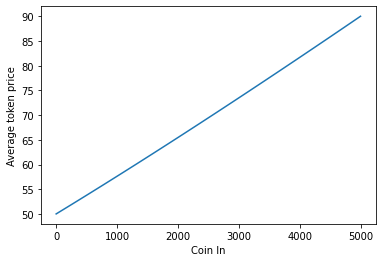

In [57]:
_ = plt.plot(coin_in, avg_price)
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Average token price')

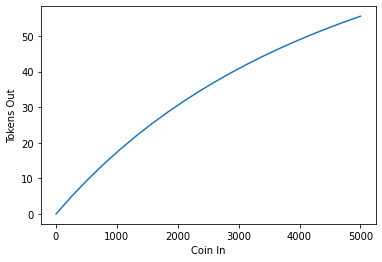

In [58]:
_ = plt.plot(coin_in, tok_out)
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Tokens Out')

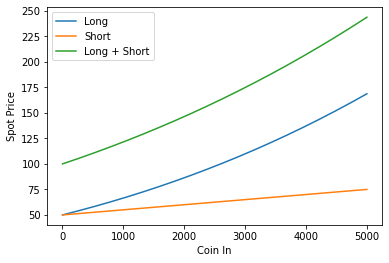

In [59]:
# Spot prices and sum
spot_prices = np.array([get_amm_spot_prices(s) for s in states])
_ = plt.plot(coin_in, spot_prices)
_ = plt.plot(coin_in, np.sum(spot_prices, axis=1))
_ = plt.legend(['Long', 'Short', 'Long + Short'])
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Spot Price')

### Price impact for selling position tokens

In [60]:
initial_state = set_amm_state(10000, 100, 100, 0.5, 100)
tok_in = np.linspace(1., 5000., 20)
states, coin_out, avg_price = zip(*[simple_swap_to_coin(initial_state, t) for t in tok_in])

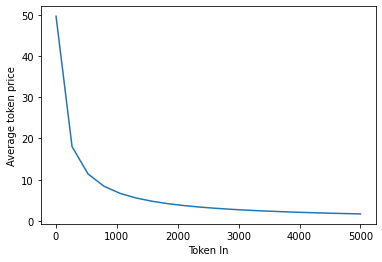

In [61]:
_ = plt.plot(coin_in, avg_price)
_ = plt.xlabel('Token In')
_ = plt.ylabel('Average token price')

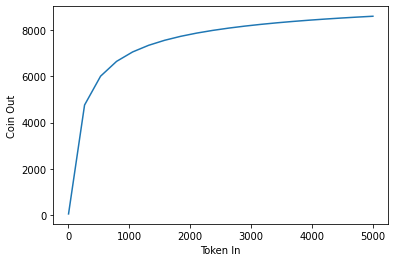

In [62]:
_ = plt.plot(tok_in, coin_out)
_ = plt.xlabel('Token In')
_ = plt.ylabel('Coin Out')

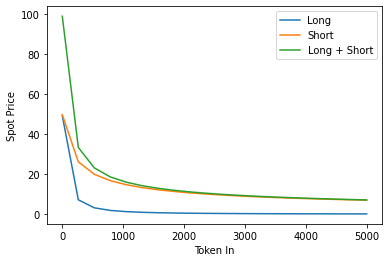

In [63]:
# Spot prices and sum
spot_prices = np.array([get_amm_spot_prices(s) for s in states])
_ = plt.plot(tok_in, spot_prices)
_ = plt.plot(tok_in, np.sum(spot_prices, axis=1))
_ = plt.legend(['Long', 'Short', 'Long + Short'])
_ = plt.xlabel('Token In')
_ = plt.ylabel('Spot Price')

## Trading - swaps with minting
The simple swap from coin to a position token increases the price of the other position token as well, which creates an arbitrage opportunity.  To avoid this we instead mint a long and short pair from the input coin then swap the unwanted position.

In [78]:
def mint_swap_from_coin(
    state, aI, to_long=True, sF=0, coin_per_pair=1,
    rebalance=False, rebalance_fun=set_amm_state):
    """Swap a_c coins in for specified token (1=L, 2=S)
    """
    tok_ind = 1 if to_long else 2
    coin_ind = 2 if to_long else 1  # The 'coin' we are using here is the other position token
    n_tok = len(state) // 2
    # calc_out_given_in(bO, wO, bI, wI, aI, sF=0)
    bO = state[tok_ind]
    wO = state[tok_ind + n_tok]
    bI = state[coin_ind]
    wI = state[coin_ind + n_tok]
    a_mint = aI/coin_per_pair  # Mint long + short pair
    aO = calc_out_given_in(bO, wO, bI, wI, a_mint, sF) + a_mint
    avg_price = aI / aO  # Price paid to AMM in coin for each position token
    if to_long:
        new_state = [
            state[0] ,
            state[1] - aO,
            state[2] + a_mint,
            state[3], state[4], state[5]
        ]
    else:
        new_state = [
            state[0] ,
            state[1] + a_mint,
            state[2] - aO,
            state[3], state[4], state[5]
        ]
    if rebalance:
        new_spot = get_amm_spot_prices(new_state)
        new_state = rebalance_fun(
            new_state[0], new_state[1], new_state[2],
            new_spot[0]/(new_spot[0] + new_spot[1]),
            coin_per_pair
        )
    
    return new_state, aO, avg_price

In [79]:
mint_swap_from_coin(initial_state, 50, coin_per_pair=100)

([10000,
  99.0024875621891,
  100.5,
  0.500000000000000,
  0.250000000000000,
  0.250000000000000],
 0.997512437810943,
 50.1246882793019)

In [66]:
# Price impact for range of long token purchases
initial_state = set_amm_state(10000, 100, 100, 0.5, 100)
coin_in = np.linspace(1., 5000., 20)
states, tok_out, avg_price = zip(*[mint_swap_from_coin(initial_state, c, coin_per_pair=100) for c in coin_in])

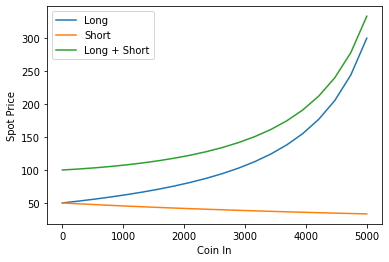

In [67]:
# Spot prices and sum
spot_prices = np.array([get_amm_spot_prices(s) for s in states])
_ = plt.plot(coin_in, spot_prices)
_ = plt.plot(coin_in, np.sum(spot_prices, axis=1))
_ = plt.legend(['Long', 'Short', 'Long + Short'])
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Spot Price')

#### Spot prices for purchasing position token then rebalancing
After doing the swap we can keep the same token balances but reweight to keep the invariant L + S = C

In [68]:
# Price impact for range of long token purchases
initial_state = set_amm_state(10000, 100, 100, 0.5, 100)
coin_in = np.linspace(1., 5000., 20)
states, tok_out, avg_price = zip(
    *[mint_swap_from_coin(initial_state, c, coin_per_pair=100, rebalance=True) for c in coin_in])

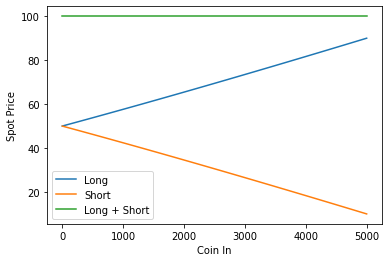

In [69]:
# Spot prices and sum
spot_prices = np.array([get_amm_spot_prices(s) for s in states])
_ = plt.plot(coin_in, spot_prices)
_ = plt.plot(coin_in, np.sum(spot_prices, axis=1))
_ = plt.legend(['Long', 'Short', 'Long + Short'])
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Spot Price')

#### Price comparison 
Compare average price per token between simple swap and mint swap

In [70]:
simple_swap_from_coin([x_c, x_l, x_s, w_c, w_l, w_s], a_c)[2]

a_c/(x_l*(1 - (x_c/(a_c + x_c))**(w_c/w_l)))

In [71]:
mint_swap_from_coin(
    [x_c, x_l, x_s, w_c, w_l, w_s], 
    a_c, coin_per_pair=C, rebalance=False)[2]

a_c/(x_l*(1 - (x_s/(x_s + a_c/C))**(w_s/w_l)) + a_c/C)

# Pool balance
What is the value of the assets in the pool?  
* A conservative option is to count only coin and paired tokens in which case value is $x_c + \min(x_l, x_s)*C$.  
* A less conservative option uses the spot price of all assets in pool in which case value is $x_c + x_l*v_l*C + x_s*v_s*C$ where the current spot price fractions $v_p, v_s$ reflect the pool spot price taking into account position imbalances i.e. $v_p = \frac{x_c}{x_l}\frac{w_l}{w_c}/C$ etc.

Use the latter value function for the moment and see how we can rebalance the pool after swap to keep the value constant.

In [75]:
def get_amm_balance(state):
    spot_prices = get_amm_spot_prices(state)
    return state[0] + state[1]*spot_prices[0] + state[2]*spot_prices[1]

In [76]:
get_amm_balance(initial_state)

20000.0000000000

In [161]:
# Price impact for range of long token purchases
initial_state = set_amm_state(10000, 100, 100, 0.5, 100)
coin_in = np.linspace(1., 5000., 20)
# With reweighting of tokens to achieve sum pf prices equal to collateral
states, tok_out, avg_price = zip(
    *[mint_swap_from_coin(initial_state, c, coin_per_pair=100, rebalance=True) for c in coin_in])
# No rebalancing, raw L->S (or S->L) swap
states_raw, tok_out_raw, avg_price_raw = zip(
    *[mint_swap_from_coin(initial_state, c, coin_per_pair=100, rebalance=False) for c in coin_in])

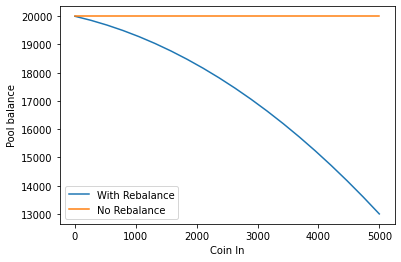

In [162]:
# Pool balance
balances = np.array([get_amm_balance(s) for s in states])
balances_raw = np.array([get_amm_balance(s) for s in states_raw])
_ = plt.plot(coin_in, balances)
_ = plt.plot(coin_in, balances_raw) # No rebalance
_ = plt.legend(['With Rebalance', 'No Rebalance'])
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Pool balance')

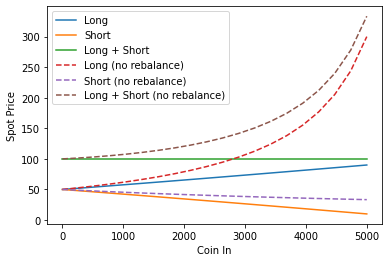

In [164]:
# Spot prices and sum
spot_prices = np.array([get_amm_spot_prices(s) for s in states])
spot_prices_raw = np.array([get_amm_spot_prices(s) for s in states_raw])

_ = plt.plot(coin_in, spot_prices)
_ = plt.plot(coin_in, np.sum(spot_prices, axis=1))
_ = plt.plot(coin_in, spot_prices_raw, linestyle='--')
_ = plt.plot(coin_in, np.sum(spot_prices_raw, axis=1), linestyle='--')
_ = plt.legend(['Long', 'Short', 'Long + Short', 
                'Long (no rebalance)', 'Short (no rebalance)', 'Long + Short (no rebalance)'])
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Spot Price')

In [146]:
def set_amm_state_constant_balance(state, orig_balance, C, sF=0):
    """Keep balance constant by minting and reweighting  
    L price = v*C, S price = (1-v)*C where C is the coin needed to mint 1 L + 1 S 
    """
    x_c, x_l, x_s, w_c, w_l, w_s = state
    x_m, w_m_l, w_m_s = sp.symbols('x_m w_m_l w_m_s')
    spot_long = calc_spot_price(x_c - C*x_m, w_c, x_l + x_m, w_l, sF)
    spot_short = calc_spot_price(x_c - C*x_m, w_c, x_s + x_m, w_s, sF)
    new_balance = (
        (x_c - C*x_m) + 
        spot_long * (x_l + x_m) +
        spot_short * (x_l + x_m)
    )
    
    eqs = [  
        new_balance - orig_balance,  # Same balance
        spot_long + spot_short - C,  # Sum of spot prices = C
        w_m_l + w_m_s
    ]
    unknowns = [x_m, w_m_l, w_m_s]
    sol = sp.solve(eqs, unknowns)
    return eqs, unknowns, sol
#     return [
#         x_c - C*sol[x_m], 
#         x_l + sol[x_m], 
#         x_s + sol[x_m], 
#         sol[w_c] - sol[w_m], 
#         sol[w_l] + sol[w_m], 
#         sol[w_s] + sol[w_m]
#     ]

In [182]:
def set_amm_state_constant_weight(state, v, C, sF=0):
    """For fixed weights calculate the token balances needed to achieve 
    L price = v*C, S price = (1-v)*C where C is the coin needed to mint 1 L + 1 S 
    """
    x_c, x_l, x_s, w_c, w_l, w_s = state
    x_m, w_m_l, w_m_s = sp.symbols('x_m w_m_l w_m_s')
    spot_long = calc_spot_price(x_c - C*x_m, w_c, x_l + x_m, w_l, sF)
    spot_short = calc_spot_price(x_c - C*x_m, w_c, x_s + x_m, w_s, sF)
    new_balance = (
        (x_c - C*x_m) + 
        spot_long * (x_l + x_m) +
        spot_short * (x_l + x_m)
    )
    
    eqs = [  
#         new_balance - orig_balance,  # Same balance
        spot_long - v*C,
#         spot_short - (1-v)*C,  # Sum of spot prices = C
    ]
    unknowns = [x_m]
    sol = sp.solve(eqs, unknowns)
#     return eqs, unknowns, sol
    return [
        x_c - C*sol[x_m], 
        x_l + sol[x_m], 
        x_s + sol[x_m], 
        w_c, 
        w_l, 
        w_s
    ]

In [147]:
set_amm_state_constant_balance(initial_state, get_amm_balance(initial_state), 100)

([-100*x_m + 2*(20000.0 - 200.0*x_m)*(x_m + 100)/(4.0*x_m + 400.0) - 10000.0,
  2*(20000.0 - 200.0*x_m)/(4.0*x_m + 400.0) - 100,
  w_m_l + w_m_s],
 [x_m, w_m_l, w_m_s],
 [(0.0, -w_m_s, w_m_s)])

In [157]:
set_amm_state_constant_balance(
    mint_swap_from_coin(initial_state, 100, coin_per_pair=100, rebalance=False)[0], 
    get_amm_balance(initial_state), 100)

([-100*x_m + (20000.0 - 200.0*x_m)*(x_m + 98.009900990099)/(4.0*x_m + 404.0) + (20000.0 - 200.0*x_m)*(x_m + 98.009900990099)/(4.0*x_m + 392.039603960396) - 10000.0,
  (20000.0 - 200.0*x_m)/(4.0*x_m + 404.0) + (20000.0 - 200.0*x_m)/(4.0*x_m + 392.039603960396) - 100,
  w_m_l + w_m_s],
 [x_m, w_m_l, w_m_s],
 [])

In [155]:
get_amm_balance(mint_swap_from_coin(initial_state, 1000, coin_per_pair=100, rebalance=True)[0])

19323.8095238095

In [156]:
get_amm_balance(mint_swap_from_coin(initial_state, 1000, coin_per_pair=100, rebalance=False)[0])

20000.0000000000

In [160]:
mint_swap_from_coin(initial_state, 1000, coin_per_pair=100, rebalance=False)[0]

[10000,
 80.9090909090909,
 110.0,
 0.500000000000000,
 0.250000000000000,
 0.250000000000000]

In [186]:
get_amm_balance(set_amm_state_constant_weight(
    mint_swap_from_coin(initial_state, 1000, coin_per_pair=100, rebalance=False)[0], 
    0.5, 
    100
))

18090.9090909091

In [176]:
a,b,c,d,e,f = initial_state

In [181]:
d

0.500000000000000

In [187]:
initial_state

[10000, 100, 100, 0.500000000000000, 0.250000000000000, 0.250000000000000]

In [188]:
get_amm_balance(initial_state)

20000.0000000000

In [189]:
get_amm_spot_prices(initial_state)

[50.0000000000000, 50.0000000000000]

Original strategy: swap C for L directly

In [199]:
buy_long_no_mint = simple_swap_from_coin(initial_state, 500)[0]

In [200]:
buy_long_no_mint

[10500,
 90.7029478458050,
 100,
 0.500000000000000,
 0.250000000000000,
 0.250000000000000]

In [201]:
get_amm_spot_prices(buy_long_no_mint)

[57.8812500000000, 52.5000000000000]

In [202]:
get_amm_balance(buy_long_no_mint)

21000.0000000000

Problem: both token prices go up

Modification: rebalance to scale weights such that sum of long and short spot price equal collateral

In [220]:
buy_long_no_mint_rebalance = simple_swap_from_coin(initial_state, 500, coin_per_pair=100, rebalance=True)[0]

In [221]:
buy_long_no_mint_rebalance

[10500,
 90.7029478458050,
 100,
 0.524672469623600,
 0.237663765188200,
 0.237663765188200]

In [222]:
get_amm_spot_prices(buy_long_no_mint_rebalance)

[52.4375743162901, 47.5624256837099]

In [223]:
get_amm_balance(buy_long_no_mint_rebalance)

20012.4851367420

This looks good!  Sum of prices = 100, and balance has increased slightly (even without fees)

In [190]:
buy_long_no_reweight = mint_swap_from_coin(initial_state, 500, coin_per_pair=100, rebalance=False)[0]

In [191]:
buy_long_no_reweight

[10000,
 90.2380952380952,
 105.0,
 0.500000000000000,
 0.250000000000000,
 0.250000000000000]

In [192]:
get_amm_balance(buy_long_no_reweight)

20000.0000000000

In [193]:
get_amm_spot_prices(buy_long_no_reweight)

[55.4089709762533, 47.6190476190476]

Try achieving L + S = C by minting extra L and S

In [212]:
minted = 1.45
wt_change = 0.1
minted_state = [10000 - 100*minted,
 90.2380952380952 + minted,
 105.0 + minted,
 0.500000000000000 - wt_change,
 0.250000000000000 + wt_change/2,
 0.250000000000000 + wt_change/2]

In [213]:
get_amm_spot_prices(minted_state)

[80.61297359058923, 69.4340065758572]

In [211]:
get_amm_balance(minted_state)

19710.0

If we reweight the overall balance decreases

In [194]:
buy_long_reweight = mint_swap_from_coin(initial_state, 500, coin_per_pair=100, rebalance=True)[0]

In [195]:
buy_long_reweight

[10000,
 90.2380952380952,
 105.0,
 0.507457144625287,
 0.246271427687356,
 0.246271427687357]

In [196]:
get_amm_spot_prices(buy_long_reweight)

[53.7804878048778, 46.2195121951220]

In [197]:
get_amm_balance(buy_long_reweight)

19706.0975609756